# GitHub Data for OpenShift Origins

In this notebook we will quickly walk through how to access and start analyzing the PR data for the OpenShift origins repository. The ultimate hope for this work is that we will be able to connect the Github data (code changes) directly with the Bugs, Telemetry, TestGrid and Prow datasets in order to develop a complete picture of the OpenShift CI process.   

## Data Collection:

The Thoth team already developed a tool for collecting data and perfoming analysis on GitHub repositoreis, [MI-Scheduler](https://github.com/thoth-station/mi-scheduler). So, we will not be accessing the data directly from GitHub, but from ceph storage after requesting that the OpenShift/Origin repo be included in the MI-Scheduler tool (see [issue](https://github.com/thoth-station/mi-scheduler/issues/130) for details).    

In [1]:
import os
import pandas as pd
import boto3
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (20, 10)})

In [2]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")
s3_input_data_path = "raw_data"
REMOTE = os.getenv("REMOTE")

In [3]:
data_path = "../../../data/raw/GitHub/PullRequest.json.gz"

if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, "thoth/mi/openshift/origin/PullRequest.json")
    file = content.get()["Body"].read().decode("utf-8")
    prs = json.loads(file)

    with gzip.open(data_path, "wb") as out_file:
        out_file.write(json.dumps(prs).encode("utf-8"))

else:
    print("getting dataset from local")
    with gzip.open(data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))


pr_df = pd.DataFrame(prs).T

getting dataset from ceph


In [4]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files
26100,bug 1949306: add e2e test to block usage of re...,Right now this is set to flake in CI and provi...,XXL,deads2k,1619104429,1619253940,openshift-merge-robot,1619253940,2,135,"{'deads2k': 1, 'openshift-ci-robot': 307, 'stt...",{},"[approved, bugzilla/severity-urgent, bugzilla/...","[13b0e99d5f35d85998af9f07eb0c5b7d6fcc0dd0, 0c3...","[go.mod, go.sum, test/extended/apiserver/api_r..."
26099,bug 1951705: allow HighOverallControlPlaneCPU ...,adding the alert in https://github.com/openshi...,XS,deads2k,1619091511,1619113470,openshift-merge-robot,1619113470,1,1,"{'openshift-ci-robot': 508, 'deads2k': 43, 'op...",{},"[approved, bugzilla/severity-high, bugzilla/va...",[7bc10c83eea29010f3b735c41847d43a992f606c],[test/extended/prometheus/prometheus.go]


## Inspect the dataset

Let's unroll a single row and see what kind of information we have access to. 

In [5]:
pr = pr_df.iloc[4]
pr

title                                   Bug 1949050: fix images.sh script
body                    This is a followup to https://github.com/opens...
size                                                                    S
created_by                                                        soltysh
created_at                                                     1618993979
closed_at                                                      1619069721
closed_by                                           openshift-merge-robot
merged_at                                                      1619069721
commits_number                                                          1
changed_files_number                                                    2
interactions            {'openshift-ci-robot': 279, 'soltysh': 2, 'ope...
reviews                 {'641526396': {'author': 'adambkaplan', 'words...
labels                  [approved, bugzilla/severity-high, bugzilla/va...
commits                        [06830a

</br>

#### **Available Fields:**

* **title**: text providing a short description of the of the PR.

* **body**: text providing additional details regarding the changes. 

* **size**: categorical label generated by GitHub summerizing the size of the changes made to the code base. 

* **created/closed/merged_at**: timestamps for when the PR was opened, merged and finally closed. 

* **created/closed_by**: usernames for contributors who created the PR and closed it. 

* **commits_number**: integer indicating the number of commits in the PR.

* **changed_files_number**: integer indicating the number of files changed.

The remaining fields appear to be collections of items, let's unroll each one and see what additional information they provide.


In [6]:
pr["interactions"]

{'openshift-ci-robot': 279,
 'soltysh': 2,
 'openshift-bot': 180,
 'openshift-ci[bot]': 79}

**interactions**: a dictionary with usernames for keys and the number of times they interacted with the PR as the value.

In [7]:
pr["reviews"]

{'641526396': {'author': 'adambkaplan',
  'words_count': 1,
  'submitted_at': 1619032331,
  'state': 'APPROVED'}}

**reviews**: a dictionary of reviews that includes an id number key along with fields for author, word_count, submitted timestamp and state of review.

In [8]:
pr["labels"]

['approved', 'bugzilla/severity-high', 'bugzilla/valid-bug', 'lgtm']

**labels**: a list of labels tagged to the PR describing some of its attributes

In [9]:
pr["commits"]

['06830a927241a44ae24e9a4b5b2ac75f666d36bc']

**commits**: a list of commit hashes that point to specific changes made to the repo's history

In [10]:
print(len(pr["changed_files"]))
pr["changed_files"][0:10]

2


['test/extended/testdata/bindata.go',
 'test/extended/testdata/cmd/test/cmd/images.sh']

**changed_files**: a list of the paths and filenames for every file changed by this PR.

We now know what we have access to in this dataset. It is a collection of numerical, categorical and textual features used to describe a PR. This gives us a lot of potential avenues to explore from an EDA and Data Science perspective. But is also creates an additional challenge insofar as we'll need to do a bit of feature engineering to get this data into format that is ready to be ingested by any ML models. 

## Example feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 


**Text Fields**

There is a whole sub-field (NLP) dedicated to analyzing text and encoding it into numerical representations. However, I want to do something simple here, so I will derive a feature called `body_size` which will simply be the number of words in the body of the PR. I will then use this numerical value to describe the body of the PR.  

**Timestamps**

When something was created or closed is somewhat arbitary outside of a timeseries analysis. Let's try and convert these values into something more comparable. I will derive a new feature called `time_to_merge` which will be the difference between the created_at and mereged_at fields. 

**New DataFrame**

With my two new derived metrics, I will create a dataframe with a subset of only numerical features that I can compare directly and start to do some lite analysis on.

In [11]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].fillna(0).astype("int")
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

# subset DataFrame
feature_df = pr_df[["body_size", "time_to_merge", "changed_files_number"]]

In [12]:
feature_df.head(2)

,body_size,time_to_merge,changed_files_number
26100,37,149511,135
26099,30,21959,1


In [13]:
feature_df.describe()

,body_size,time_to_merge,changed_files_number
count,17183.000000,1.718300e+04,17183.000000
mean,31.476867,5.355716e+05,68.379910
std,66.186398,1.663580e+06,885.774654
min,0.000000,0.000000e+00,0.000000
25%,3.000000,5.465500e+03,1.000000
50%,14.000000,7.605000e+04,2.000000
75%,36.000000,3.629760e+05,6.000000
max,2899.000000,5.500529e+07,48386.000000


Let's look at some pair-wise scatter plots of our data to see if there are any obvious correlations between our features. 

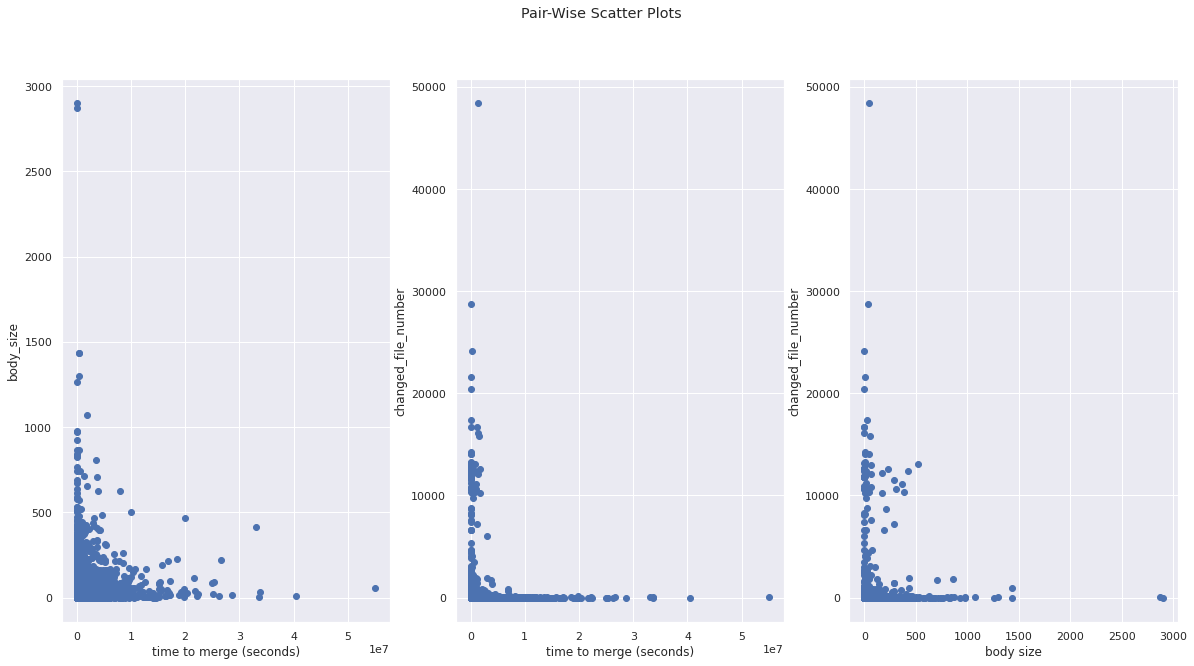

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(feature_df["time_to_merge"], feature_df["body_size"])
ax1.set(xlabel="time to merge (seconds)", ylabel="body_size")
ax2.scatter(feature_df["time_to_merge"], feature_df["changed_files_number"])
ax2.set(xlabel="time to merge (seconds)", ylabel="changed_file_number")
ax3.scatter(feature_df["body_size"], feature_df["changed_files_number"])
ax3.set(xlabel="body size", ylabel="changed_file_number")
fig.suptitle("Pair-Wise Scatter Plots")
plt.show()

Its tough to see any meaningfull correlations here. Despite this "L" shaped scatter plot the vast majority of the points are centered around (0,0) in all 3 cases. Let's calculate the correlation value for each pair of variables to see some actaul numbers.

In [15]:
feature_df.corr()

,body_size,time_to_merge,changed_files_number
body_size,1.000000,0.076079,0.028810
time_to_merge,0.076079,1.000000,-0.005893
changed_files_number,0.028810,-0.005893,1.000000


Here we can see that body_size is _most_ correlated with time_to_merge, but 0.07 is a rather weak correlation value. This is good if we are going to use these as input features to a model, but not so good if we wanted to try and predict one value from the other two. Looks like we will need to go back and engineer some more features.

### Conlusion

This notebook walked through how to access the relevant PR data for the OpenShift Origin project we whish to analyze along with the rest of the related CI data in this project. We also outlined what is contained in each record and provided a quick demonstration of how to convert the mixed data types into numerical values for statistical analysis and eventually machine learning. 

We will continue to explore the provided data and perform additional feature engineering in a forthcoming notebook.